In [1]:
# start jupyter notebooks from prompt to load all required libraries
# jupyter notebook
import cv2

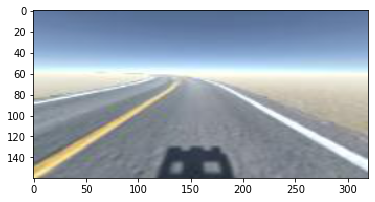

In [3]:
import matplotlib.image as mpimg
fp = '/home/simbox/git/msc-data/unity/log2/logs_Fri_Jul_10_09_16_18_2020/10000_cam-image_array_.jpg'
# fp = '/home/simbox/Downloads/IMG/center_2020_11_10_22_02_48_622.jpg'
img = mpimg.imread(fp)
# adapt to naoki net, we have 160w x 120h, first scale to 200 
img = cv2.resize(img, (320,160), cv2.INTER_AREA)
import matplotlib.pyplot as plt
plt.imshow(img)
#plt.imshow(img)\n",
# plt.imshow(img[61:-25, :, :]) # image is 120h160w3d: 60:-25 ~ start at h pixel index 60, end at index (120) - 25
                              # equivalent to img[60:95, :, :]
                              # plain english: remove sky and car shadow
# print(img[59:-25, :, :].shape)
    # img[50:-25, :, :].shape"

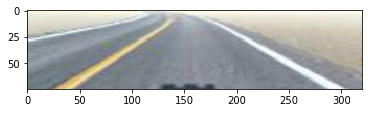

In [8]:
# first resize
image = load_image(fp)
image = cv2.resize(image, (320, 160), cv2.INTER_AREA)
image = crop(image)
plt.imshow(image)

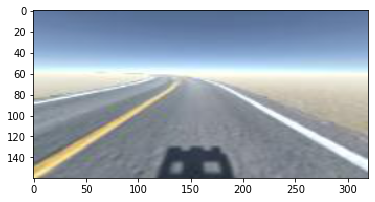

In [33]:
image = load_image(fp)
image = cv2.resize(image, (320, 160), cv2.INTER_AREA)
steering_angle = 0.07
# image, steering_angle = augment(image, steering_angle)
# image = crop(image)
# image = crop(image)
# image = resize(image)
# image = rgb2yuv(image)
# print(steering_angle)
plt.imshow(image) 
    

In [2]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg

# Udacity
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 320, 3
# Alexnet
#IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 224, 224, 3
# IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
# IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 120, 160, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
# Dimensions expected by network
# Udacity
IMAGE_WIDTH_NET, IMAGE_HEIGHT_NET = 200, 66
# Alexnet
# IMAGE_WIDTH_NET, IMAGE_HEIGHT_NET = 224, 224



def load_image(image_path):
    """
    Load RGB images from a file
    """
    return mpimg.imread(image_path)


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    # unity
    # return image[60:-25, :, :] # remove the sky and the car front
    # alexnet
    return image[109:-40, :, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH_NET, IMAGE_HEIGHT_NET), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    # could this be a bug?
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    # xm, ym = np.mgrid[0:IMAGE_WIDTH, 0:IMAGE_HEIGHT]
    
    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augment(image, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    # resize - we start with assumed image capture size
    image = cv2.resize(image, (320,160), cv2.INTER_AREA)
    # image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle


def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers



(120, 160, 3)
Expected (120, 160, 3) nvidia1


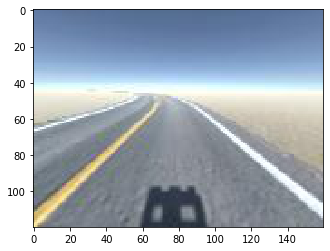

In [11]:
# cropping test nvidia1

def crop(image, top_crop, bot_crop):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    # unity
    return image[top_crop:bot_crop, :, :] # remove the sky and the car front
    # alexnet
    # return image[100:-50, :, :] # remove the sky and the car front

import matplotlib.pyplot as plt
IMAGE_WIDTH, IMAGE_HEIGHT = 160, 120
fp = '/home/simbox/git/msc-data/unity/log2/logs_Fri_Jul_10_09_16_18_2020/10000_cam-image_array_.jpg'
image = load_image(fp)
image_resized = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
# plt.imshow(image)
plt.imshow(image_resized)
print(image_resized.shape)
print("Expected (120, 160, 3) nvidia1")

nvidia1 crop (35, 160, 3)
(35, 160, 3)


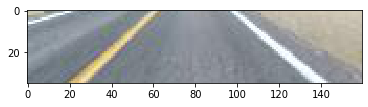

In [12]:
image_nvidia1_crop = crop(image_resized, 60, -25)
# cropping test
print("nvidia1 crop (35, 160, 3)")
print(image_nvidia1_crop.shape)
plt.imshow(image_nvidia1_crop)

(120, 160, 3)
nvidia1 resized


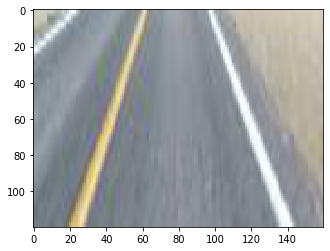

In [14]:
image_nvidia_crop_resized = cv2.resize(image_nvidia1_crop, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
print(image_nvidia_crop_resized.shape)
print("nvidia1 resized")
plt.imshow(image_nvidia_crop_resized)

(160, 320, 3)
Expected (160, 320, 3) nvidia1


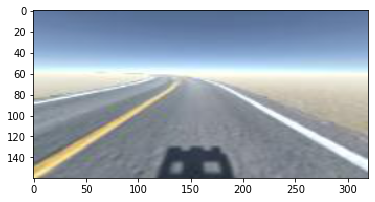

In [25]:
# cropping test nvidia2

import matplotlib.pyplot as plt
IMAGE_WIDTH, IMAGE_HEIGHT = 320, 160
image_resized = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
# plt.imshow(image)
plt.imshow(image_resized)
print(image_resized.shape)
print("Expected (160, 320, 3) nvidia1")

nvidia2 70 -35 crop (55, 320, 3)
(55, 320, 3)


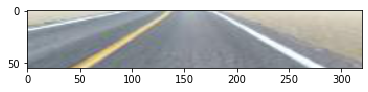

In [26]:
image_nvidia2_crop_70_35 = crop(image_resized, 70, -35)
# cropping test
print("nvidia2 70 -35 crop (55, 320, 3)")
print(image_nvidia2_crop_70_35.shape)
plt.imshow(image_nvidia2_crop_70_35)

(160, 320, 3)
nvidia1 crop 70 -35 resized


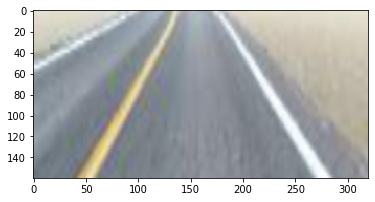

In [27]:
image_nvidia_crop_70_35_resized = cv2.resize(image_nvidia2_crop_70_35, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
print(image_nvidia_crop_70_35_resized.shape)
print("nvidia1 crop 70 -35 resized")
plt.imshow(image_nvidia_crop_70_35_resized)

nvidia2 91 -35 crop (35, 160, 3)
(34, 320, 3)


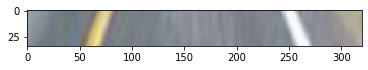

In [20]:
image_nvidia2_crop_91_35 = crop(image_resized, 91, -35)
# cropping test
print("nvidia2 91 -35 crop (35, 160, 3)")
print(image_nvidia2_crop_91_35.shape)
plt.imshow(image_nvidia2_crop_91_35)

(160, 320, 3)
Expected (160, 320, 3) nvidia1


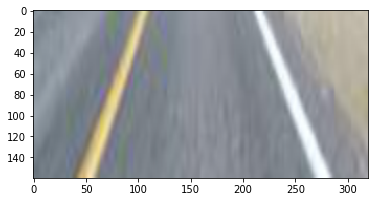

In [19]:
IMAGE_WIDTH, IMAGE_HEIGHT = 320, 160
image_resized = cv2.resize(image_nvidia2_crop_91_35, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
# plt.imshow(image)
plt.imshow(image_resized)
print(image_resized.shape)
print("Expected (160, 320, 3) nvidia2")

(160, 320, 3)
Expected (160, 320, 3) nvidia1


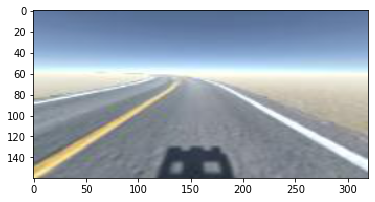

In [21]:
# cropping test nvidia2 - higher crop to include all road markings


import matplotlib.pyplot as plt
IMAGE_WIDTH, IMAGE_HEIGHT = 320, 160
image_resized = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
# plt.imshow(image)
plt.imshow(image_resized)
print(image_resized.shape)
print("Expected (160, 320, 3) nvidia1")

nvidia2 81 -35 crop (35, 160, 3)
(44, 320, 3)


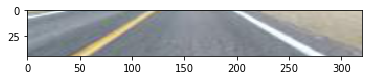

In [32]:
image_nvidia2_crop_81_35 = crop(image_resized,81, -35)
# cropping test
print("nvidia2 81 -35 crop (35, 160, 3)")
print(image_nvidia2_crop_81_35.shape)
plt.imshow(image_nvidia2_crop_81_35)

(160, 320, 3)
Expected (160, 320, 3) nvidia2


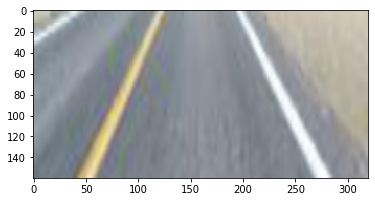

In [33]:
IMAGE_WIDTH, IMAGE_HEIGHT = 320, 160
image_resized = cv2.resize(image_nvidia2_crop_81_35, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
# plt.imshow(image)
plt.imshow(image_resized)
print(image_resized.shape)
print("Expected (160, 320, 3) nvidia2")

(66, 200, 3)


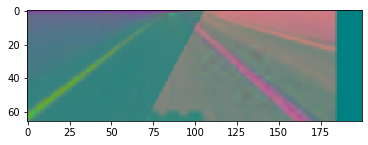

In [64]:
# images for dissertation - Augmentation section
# Finally move from RGB to YUV colour space
image = load_image(fp)
image = cv2.resize(image, (320, 160), cv2.INTER_AREA)
steering_angle = 0.07
image, steering_angle = augment(image, steering_angle)
image = crop(image)
image = resize(image)
image = rgb2yuv(image)
# print(steering_angle)
plt.imshow(image) 
print(image.shape) # original size of this image: 120 x 160

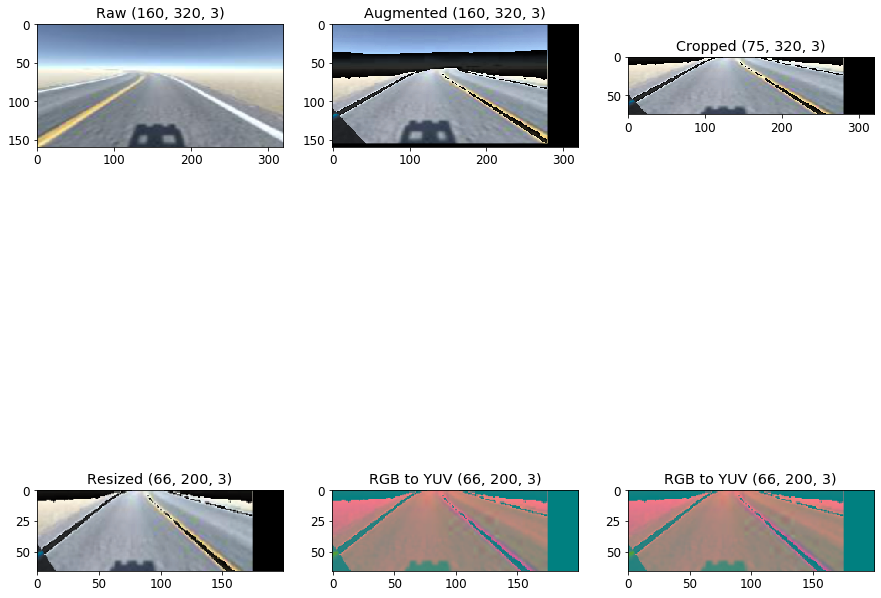

In [103]:
# images for dissertation - Augmentation section
image = load_image(fp)
image1 = cv2.resize(image, (320, 160), cv2.INTER_AREA) # original NVIDIA capture size
steering_angle = 0.07
image2, steering_angle = augment(image1, steering_angle) # augmented
image3 = crop(image2) # cropped
image4 = resize(image3) # resized to network design
image5 = rgb2yuv(image4) # RGB to YUV transform
# print(steering_angle)
#plt.imshow(image) 
#print(image.shape) # original size of this image: 120 x 160

# plot for dissertation - cannot adjust padding between rows so further image processing required
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 12.0

fig, axs = plt.subplots(2, 3)

fig.set_figheight(15)
fig.set_figwidth(15)

# Raw
axs[0, 0].title.set_text('Raw ' + str(image1.shape))
axs[0, 0].imshow(image1) 

# Augmented
axs[0, 1].title.set_text('Augmented ' + str(image2.shape))
axs[0, 1].imshow(image2) 

# cropped
axs[0, 2].title.set_text('Cropped ' + str(image3.shape))
axs[0, 2].imshow(image3) 

# resized
axs[1, 0].title.set_text('Resized ' + str(image4.shape))
axs[1, 0].imshow(image4) 

# RGBtoYUV
axs[1, 1].title.set_text('RGB to YUV ' + str(image5.shape))
axs[1, 1].imshow(image5) 

# Dummy to better format 
axs[1, 2].title.set_text('RGB to YUV ' + str(image5.shape))
axs[1, 2].imshow(image5) 


plt.show()

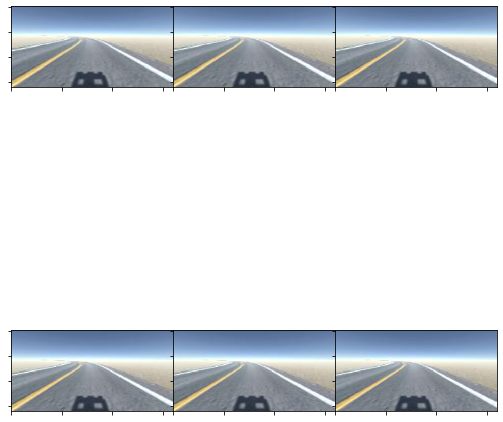

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

nrow = 2
ncol = 3

fig = plt.figure(figsize=(10, 10)) 

gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

for i in range(2):
    for j in range(3):
        im = np.random.rand(28,28)
        ax= plt.subplot(gs[i,j])
        ax.imshow(image)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

#plt.tight_layout() # do not use this!!
plt.show()